In [1]:
from _utils import *
from scipy.stats import qmc
import kmedoids
from sklearn.metrics.pairwise import euclidean_distances

folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'
    
num_monomers = 80

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:num_monomers, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:num_monomers, :, :]

esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

def calculate_distance_map(polys):
    # Extract the dimensions of the input array
    num_probes, num_coords, num_cells = polys.shape
    
    # Initialize an array of the same shape to hold the interpolated values
    new_maps = np.zeros((num_cells, num_probes, num_probes))
    
    # Iterate over each cell
    for c in range(num_cells):
        # Extract the data for the current cell
        curr_cells = polys[:, :, c]
        
        # Skip cells with all missing values
        if np.all(np.isnan(curr_cells)):
            continue  # This leaves a matrix of zeros in the output array
        
        # Calculate the pairwise Euclidean distance between each pair of probes
        dmap = squareform(pdist(curr_cells))
        
        # Assign the distance map to the corresponding position in the output array
        new_maps[c, :, :] = dmap
    
    # Return the array with interpolated values
    return new_maps

esc_maps_interp = calculate_distance_map(esc_polys_interp)
cnc_maps_interp = calculate_distance_map(cnc_polys_interp)
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp = np.concatenate((esc_maps_interp, cnc_maps_interp), axis=0)
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

2024-10-16 13:00:40.735025: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-16 13:00:41.235059: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
mcmc_common_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results'

# Find all the folders in the MCMC result directory with 'Kmedoid' in the name
mcmc_folders = [f for f in os.listdir(mcmc_common_dir) if 'Kmedoid' in f]

# Get the full path to each of the folders
mcmc_folders = [os.path.join(mcmc_common_dir, f) for f in mcmc_folders]

mcmc_folders.sort()

In [3]:
mcmc_results = []
for i, k in enumerate([10, 20, 30, 40, 50]):
    mcmc_results.append(load_mcmc_results(mcmc_folders[i], k))

  0%|          | 0/3 [00:00<?, ?it/s]

['20240715_WeightOptimization-20241015143708_1.csv', '20240715_WeightOptimization-20241015143708_2.csv', '20240715_WeightOptimization-20241015143708_3.csv', '20240715_WeightOptimization-20241015143708_4.csv']
['20240715_WeightOptimization-20241015143708_1.csv', '20240715_WeightOptimization-20241015143708_2.csv', '20240715_WeightOptimization-20241015143708_3.csv', '20240715_WeightOptimization-20241015143708_4.csv']


  0%|          | 0/3 [00:00<?, ?it/s]

['20240715_WeightOptimization-20241015143837_1.csv', '20240715_WeightOptimization-20241015143837_2.csv', '20240715_WeightOptimization-20241015143837_3.csv', '20240715_WeightOptimization-20241015143837_4.csv']
['20240715_WeightOptimization-20241015143853_1.csv', '20240715_WeightOptimization-20241015143853_2.csv', '20240715_WeightOptimization-20241015143853_3.csv', '20240715_WeightOptimization-20241015143853_4.csv']


  0%|          | 0/3 [00:00<?, ?it/s]

['20240715_WeightOptimization-20241015144032_1.csv', '20240715_WeightOptimization-20241015144032_2.csv', '20240715_WeightOptimization-20241015144032_3.csv', '20240715_WeightOptimization-20241015144032_4.csv']
['20240715_WeightOptimization-20241015144033_1.csv', '20240715_WeightOptimization-20241015144033_2.csv', '20240715_WeightOptimization-20241015144033_3.csv', '20240715_WeightOptimization-20241015144033_4.csv']


  0%|          | 0/3 [00:00<?, ?it/s]

['20240715_WeightOptimization-20241015144222_1.csv', '20240715_WeightOptimization-20241015144222_2.csv', '20240715_WeightOptimization-20241015144222_3.csv', '20240715_WeightOptimization-20241015144222_4.csv']
['20240715_WeightOptimization-20241015144244_1.csv', '20240715_WeightOptimization-20241015144244_2.csv', '20240715_WeightOptimization-20241015144244_3.csv', '20240715_WeightOptimization-20241015144244_4.csv']


  0%|          | 0/3 [00:00<?, ?it/s]

['20240715_WeightOptimization-20241015144422_1.csv', '20240715_WeightOptimization-20241015144422_2.csv', '20240715_WeightOptimization-20241015144422_3.csv', '20240715_WeightOptimization-20241015144422_4.csv']
['20240715_WeightOptimization-20241015144437_1.csv', '20240715_WeightOptimization-20241015144437_2.csv', '20240715_WeightOptimization-20241015144437_3.csv', '20240715_WeightOptimization-20241015144437_4.csv']


In [23]:
mcmc_results[0]

In [4]:
pca = PCA(n_components=2)
pca.fit(all_maps_interp_flat)
esc_maps_pca = pca.transform(esc_maps_interp_flat)
cnc_maps_pca = pca.transform(cnc_maps_interp_flat)

esc_df = pd.DataFrame(esc_maps_pca, columns=['PC1', 'PC2'])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_pca, columns=['PC1', 'PC2'])
cnc_df['label'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df], axis=0)

In [5]:
# Load parameters for medoids
md_params = []
for f in mcmc_folders:
    # load 'param.pkl' 
    with open(os.path.join(f, 'param.pkl'), 'rb') as file:
        param = pickle.load(file)
        md_params.append(param)


In [8]:
md_params[0]['microstates'].shape

(10, 6400)

In [9]:
md_microstates = []
for md in md_params:
    md_microstates.append(md['microstates'])

In [10]:
# Project microstates from different condition onto the first two PCs
md_microstates_pca = []
for md in md_microstates:
    md_pca = pca.transform(md)
    md_microstates_pca.append(md_pca)

In [22]:
# Add these to the dataframe with different labels
md_dfs = []
for i, md in enumerate(md_microstates_pca):
    md_df = pd.DataFrame(md, columns=['PC1', 'PC2'])
    md_df['label'] = 'K-medoid {}'.format(10 * (i+1))
    md_dfs.append(md_df)
md_df = pd.concat(md_dfs, axis=0)

<Axes: xlabel='PC1', ylabel='PC2'>

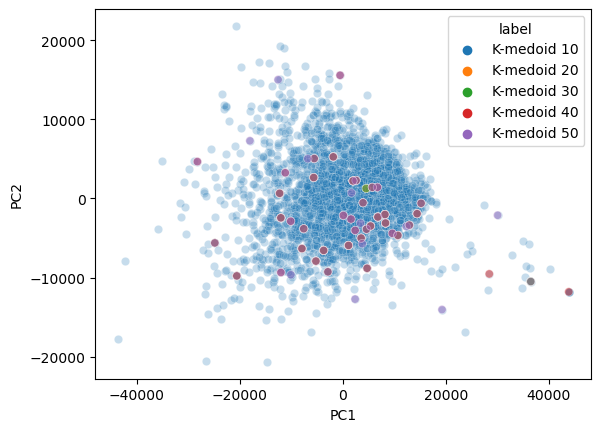

In [16]:
sns.scatterplot(data=all_df, x='PC1', y='PC2', alpha=0.25)
sns.scatterplot(data=md_df, x='PC1', y='PC2', hue='label', alpha=0.5)

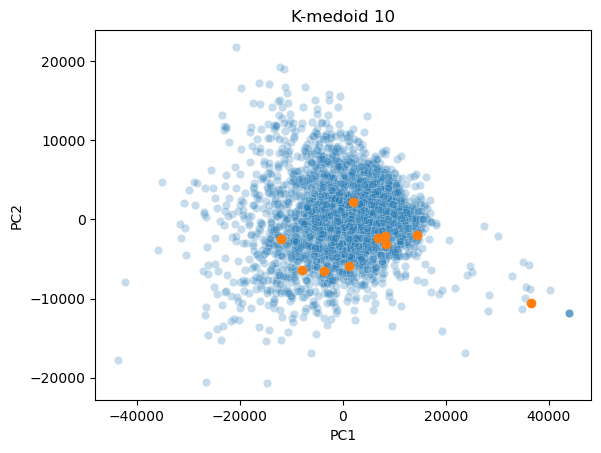

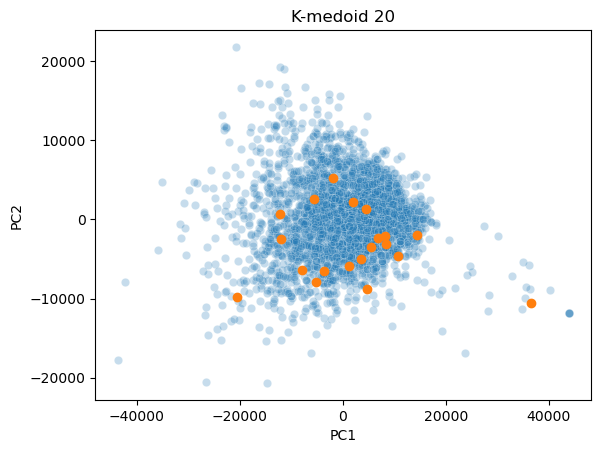

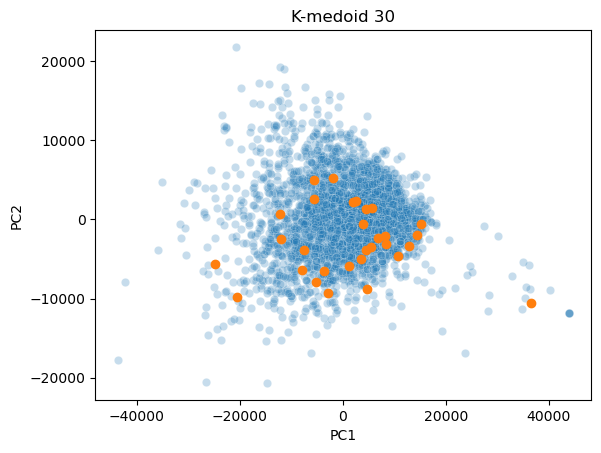

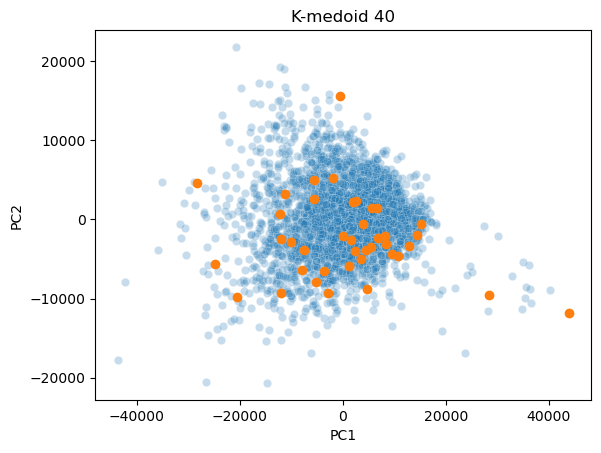

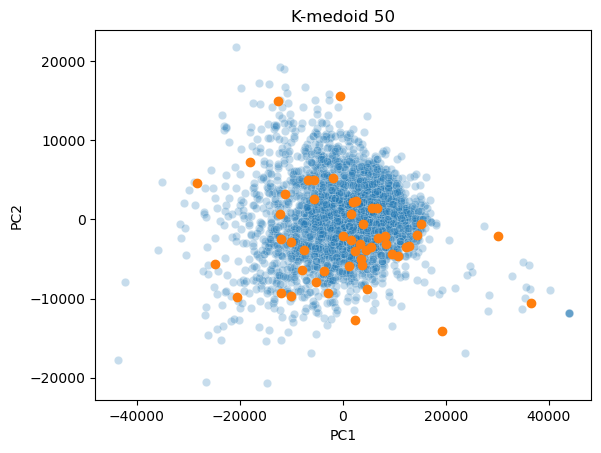

In [18]:
for i, md in enumerate(md_microstates_pca):
    sns.scatterplot(data=all_df, x='PC1', y='PC2', alpha=0.25)
    plt.scatter(md[:, 0], md[:, 1])
    plt.title('K-medoid {}'.format(10 * (i+1)))
    plt.show()

In [20]:
# Check weight distributions of these structures 
md_dfs[0]

,PC1,PC2,label
6,-12048.704843,-2449.668363,K-medoid 10
9,-7950.410317,-6336.627306,K-medoid 10
7,-3731.351663,-6569.112638,K-medoid 10
3,1099.964362,-5937.952024,K-medoid 10
5,1965.971519,2215.775750,K-medoid 10
4,6801.426241,-2345.767196,K-medoid 10
2,8172.685417,-2030.718679,K-medoid 10
0,8290.426597,-3103.517898,K-medoid 10
1,14417.463647,-1926.839236,K-medoid 10
8,36510.935779,-10500.776093,K-medoid 10
